# Inputation and integration for simulation

## loading package

In [3]:
import scanpy as sc
import torch as th
import torch.nn as nn
from matplotlib import rcParams
import sys
sys.path.append(r"/data/xiangdw/MODEL/")
from SpaMIE.create_graph import Sagegraph
from SpaMIE.spamie_main import Sagewrapper
config = {
    "font.family":'Times New Roman', 
     "font.size":20, 
    "axes.unicode_minus": False 
}
rcParams.update(config)

In [2]:
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
file_fold = '/data/xiangdw/data/data/'
a = []
layers_nums = 3
seeds = 1
adata_omics1 = sc.read_h5ad(file_fold + str(seeds) + '_simu_pred_mod2.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + str(seeds) + '_simu_pred_mod1.h5ad')

modalities = [adata_omics1, adata_omics2]
g_spatial_omics1, g_feature_omics1, adata_omics1, adata_omics2 = Sagegraph(modalities, device, datatype='simu', batch=False)
output_dir = '/data/xiangdw/data/pred result/'
weight = [0,0,1]

pred_name = 'simu_SpaMIE_'+str(layers_nums)+'_pred.csv'
true_name = 'simu_SpaMIE_'+str(layers_nums)+'_truth.csv'

in_feat = adata_omics1.obsm['feat'].shape[1]
out_feat = adata_omics2.X.shape[1]

model = Sagewrapper(seed=(int(seeds)), device=device, in_feat=in_feat, n_hidden=256, out_feat=out_feat, task='prediction', datatype='simu',
                    layers_nums=int(layers_nums), weight=weight, epoch=600, res_type='res_add', activation=nn.LeakyReLU
                    , sagetype='mean', lr=2e-4, lr2 = 0.002)

adata_omics1_pred, adata_omics2_pred, test_idx, train_idx,wt,alph  = model.fit(adata_omics1, adata_omics2, g_spatial_omics1, g_feature_omics1, 
                                                                                output_dir=output_dir, pred_name=pred_name, 
                                                                                true_name=true_name, weight=True, save_csv=False)



/data/xiangdw/MODEL/SpaMIE/spamie_net.py:98: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)


Early stopped.


## Integration

In [ ]:
import torch.nn.functional as F
from SpaMIE.create_graph import Sagegraph
from SpaMIE.spamie_main import Sagewrapper
import numpy as np
from model_integration import set_seed
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')

seeds = 1
path = '/data/xiangdw/data/data/'
adata_omics1 = sc.read_h5ad(path + str(seeds) + '_simu_pred_mod2.h5ad')
adata_omics2 = sc.read_h5ad(path + str(seeds) + '_simu_pred_mod1.h5ad')

test_idx = '/data/xiangdw/data/pred result/sage pred result/'+str(seeds)+'_simu_test_idx.csv'
y_pred_name = '/data/xiangdw/data/pred result/SpaMIE pred result/'+str(seeds)+'simu_SpaMIE_new_res3_wt_pred_50.csv'

set_seed(2024) 
modalities = [adata_omics1, adata_omics2]
g_spatial_omics1, g_feature_omics1, g_spatial_omics2,g_feature_omics2, adata_omics1, adata_omics2 = Sagegraph(modalities, device, task="Integration", test_idx_name=test_idx,
                                                                                                                y_pred_name=y_pred_name, pred_joint=True, datatype="simu",batch=False)

in_feat = adata_omics1.obsm['feat'].shape[1]
out_feat = adata_omics2.X.shape[1]
weight = [1,1,1]
model = Sagewrapper(seed=(int(seeds)), device=device, in_feat=in_feat, n_hidden=256, out_feat=out_feat, task='integration', datatype='simu',
                    layers_nums=int(3), weight=weight, epoch=600, res_type='res_add', activation=nn.LeakyReLU
                    , sagetype='mean', lr=2e-4, lr2 = 0.002)

output  = model.fit(adata_omics1, adata_omics2, g_spatial_omics1, g_feature_omics1, g_spatial_omics2, g_feature_omics2, weight_factors=[1,5,1,1])

adata_omics2.obsm['SpaMIE'] = output[0].detach().cpu().numpy()

/data/xiangdw/MODEL/SpaMIE/spamie_net.py:98: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
/data/xiangdw/MODEL/SpaMIE/spamie_net.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)


## Visualisation

Searching resolution...
resolution=0.401, cluster number=5


/data/xiangdw/conda_env/GNNS/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'SpaMIE'}, xlabel='spatial1', ylabel='spatial2'>

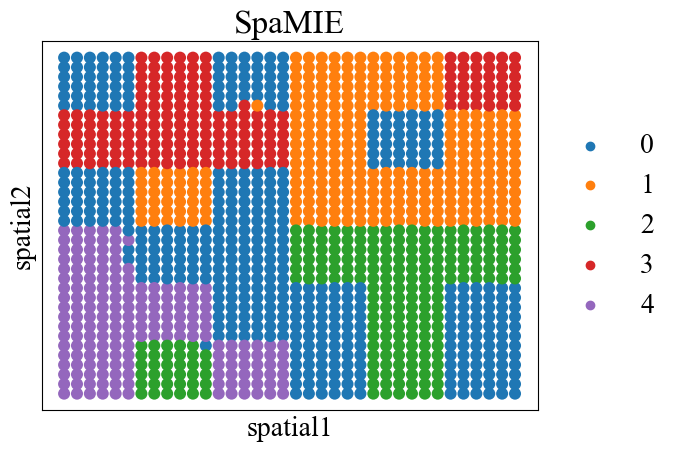

In [3]:
from SpatialGlue.utils import clustering
tool = 'louvain'
clustering(adata_omics2, key='SpaMIE', add_key='SpaMIE',start=0.001, end=0.5, increment=0.1, n_clusters=5, method=tool, use_pca=False)
sc.pl.embedding(adata_omics2, basis='spatial', color=['SpaMIE'], title='SpaMIE', s=300, show=False)